# 情感分析模型微调

# 介绍


**“文本评论和反馈的自动化情感分析”项目侧重于利用深度学习算法，特别是双向长短期记忆(BiLSTM)层，来解读文本数据中传达的情感语调和情绪。通过利用先进的自然语言处理(NLP)技术，该系统旨在彻底改变从书面反馈和评论中理解和分析情绪的方式。**

我们可以将实现分为以下几个步骤:

1.   收集的数据集
2.   文本预处理
3.   特征提取
4.   模型开发
5.   评价

# 数据集

**对于这个项目，我使用了HuggingFace情感数据集。Emotion是英文Twitter信息的数据集，包含六种基本情绪:愤怒、恐惧、喜悦、爱、悲伤和惊讶。数据集包括两列，即“text”和“label”。“text”列包含由来自不同用户的tweet组成的字符串，而“label”列包含代表情感的分类值。这些情绪包括悲伤(0)、高兴(1)、喜爱(2)、愤怒(3)、恐惧(4)和惊讶(5)。**

[hugging情感数据地址](https://huggingface.co/datasets/dair-ai/emotion/)

# 导入重要的包

In [1]:
# 安装nlp自然语言处理（Natural Language Processing）和hugging数据集
!pip install nlp
!pip install datasets

# 导入tf机器学习框架，用于构建和训练各种机器学习模型
import tensorflow as tf
# 导入科学计算的Python库，用于数据分析
import numpy as np
# 导入用于数据分析和处理的Python库
import pandas as pd
# 导入生成词云图的Python库
from wordcloud import WordCloud
# 导入基于 Matplotlib 的 Python 可视化库，用于提供一个高级界面来绘制统计图形
import seaborn as sns
# 用于绘制的图形直接嵌入到Notebook中
%matplotlib inline
# 导入plot提供绘图能力
import matplotlib.pyplot as plt
# 导入简单而高效的方式来创建复杂的可视化图表
import plotly.express as px
# 导入提供创建各种类型的图表，包括散点图、线图、柱状图、3D图等，并且可以通过详细设置调整每个元素的属性
import plotly.graph_objects as go
# 导入处理人类语言数据的Python库，tokenize是NLTK库中的一个子模块，提供了用于文本分词（tokenization）的工具和函数；corpus提供了一些常用的语言学语料库（corpora），这些语料库包含了各种文本数据，用于自然语言处理和计算语言学的研究；以及stem用于词干提取（stemming）的工具
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nlp
# 该模块是 TensorFlow 中 Keras API 的一部分，用于文本数据的预处理。这个模块提供了一些实用的工具，用于将文本数据转换为神经网络可以处理的形式，通常是数值表示，Tokenizer 类用于将文本数据转换为标记序列，每个标记对应于一个唯一的整数。它还支持设置词汇表的大小、过滤低频词汇等功能。
from tensorflow.keras.preprocessing.text import Tokenizer
# pad_sequences 函数用于将序列填充或截断为相同的长度，以便输入到神经网络中。这在处理不定长序列数据时很有用。
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Dense 和 Dropout 是深度学习中常用的层（Layer）类型，它们通常用于构建神经网络模型。
from keras.layers import Dense, Dropout
# RNN的变体，专门设计用于处理时序数据，并且在解决传统 RNN 中的梯度消失和梯度爆炸等问题上更加有效。
from keras.layers import LSTM
# Sequential 是 Keras 中定义神经网络模型的一个容器。它提供了一种简化的方式来搭建层级结构的神经网络模型。Sequential 模型是线性堆叠层的容器，层按顺序一层接一层地堆叠。
from keras.models import Sequential
# Embedding 层通常用于将词汇表中的单词映射到高维空间中的实数向量，这些向量可以作为神经网络模型的输入。
from keras.layers import Embedding
# Flatten 层通常用于连接卷积层之后的全连接层，或者将任意形状的输入展平为一维向量，以便进行后续的全连接操作。
from keras.layers import Flatten
# Bidirectional（双向）层通过在时间步骤上同时考虑输入序列的正向和反向信息，增强了模型对序列数据的建模能力。
from keras.layers import Bidirectional
# EarlyStopping 是深度学习中的一种回调（callback），用于在训练过程中监控模型性能，并在达到指定条件时提前停止训练。这有助于防止模型在过拟合的情况下过多地拟合训练数据，从而提高模型的泛化性能。
from keras.callbacks import EarlyStopping
# GlobalAvgPool1D是 Keras 中的一种池化层，用于对一维输入进行全局平均池化操作。全局平均池化的操作是对输入的每个通道（特征）取平均值，得到一个全局的标量输出。
from keras.layers import GlobalAvgPool1D
# 生成伪随机数的函数
import random

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.7 MB/s eta 0:00:00


**来自hug Face的数据集库提供了对广泛的数据集的方便访问，这些数据集通常用于NLP任务。它提供了无缝下载、预处理和处理数据集的功能，允许用户轻松地将数据集加载到机器学习或深度学习管道中。**

In [2]:
pip install dataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.6 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.23
    Uninstalling SQLAlchemy-2.0.23:
      Successfully uninstalled SQLAlchemy-2.0.23
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.50 which is incompatible.


# 导入数据集

**加载训练数据**

In [3]:
#导入情感数据集合
from datasets import load_dataset
data = load_dataset('emotion')

# 将训练、验证和测试数据集转换为DataFrame格式
train = pd.DataFrame(data['train'])
validation = pd.DataFrame(data['validation'])
test = pd.DataFrame(data['test'])

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [4]:
#展示前10条数据
train.head(10)

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
5,ive been feeling a little burdened lately wasn...,0
6,ive been taking or milligrams or times recomme...,5
7,i feel as confused about life as a teenager or...,4
8,i have been with petronas for years i feel tha...,1
9,i feel romantic too,2


**查看训练标签字典**

In [5]:
train['label'].unique()

array([0, 3, 2, 5, 4, 1])

# 文本长度数量分布

In [6]:
train['length_of_text'] = [len(i.split(' ')) for i in train['text']]

fig = px.histogram(train['length_of_text'], marginal='box',
                   labels={"value": "文本长度"})

fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout(title_text='文本长度数量分布图',
                  title_x=0.5, title_font=dict(size=22))
fig.show()

# 情感对文本长度分布的影响

In [7]:
fig = px.histogram(train['length_of_text'], marginal='box',
                   labels={"value": "文本长度"},
                   color=train['label'])
fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout(title_text='情感对文本长度的影响分布',
                  title_x=0.5, title_font=dict(size=22))
fig.show()

# 标签的分布

In [8]:
fig = px.histogram(train, x='label', color='label')
fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout(title_text='标签数量分布',
                  title_x=0.5, title_font=dict(size=22))
fig.show()

In [9]:
FreqOfWords = train['text'].str.split(expand=True).stack().value_counts()
FreqOfWords_top200 = FreqOfWords[:200]

top_words_df = pd.DataFrame({'word': FreqOfWords_top200.index, 'frequency': FreqOfWords_top200.values})

import plotly.express as px

fig = px.treemap(top_words_df, path=['word'], values='frequency')
fig.update_layout(title_text='词汇出现的次数', title_x=0.5, title_font=dict(size=22))
fig.update_traces(textinfo="label+value")
fig.show()

# 用NLTK标记化

In [10]:
# 用于文本分词、句子分割等自然语言文本处理任务
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:
def tokenization(inputs):
    return word_tokenize(inputs) #REFERENCE[1]

# 对 训练数据集 和 验证数据集 进行文本分词
train['text_tokenized'] = train['text'].apply(tokenization)
validation['text_tokenized'] = validation['text'].apply(tokenization)

In [12]:
train.head()

,text,label,length_of_text,text_tokenized
0,i didnt feel humiliated,0,4,"[i, didnt, feel, humiliated]"
1,i can go from feeling so hopeless to so damned...,0,21,"[i, can, go, from, feeling, so, hopeless, to, ..."
2,im grabbing a minute to post i feel greedy wrong,3,10,"[im, grabbing, a, minute, to, post, i, feel, g..."
3,i am ever feeling nostalgic about the fireplac...,2,18,"[i, am, ever, feeling, nostalgic, about, the, ..."
4,i am feeling grouchy,3,4,"[i, am, feeling, grouchy]"


# 停止词删除

In [13]:
# 去除停用词和符号的文本
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
stop_words = set(stopwords.words('english'))

def stopwords_remove(inputs):
    return [item for item in inputs if item not in stop_words]

# 对 训练数据集 和 验证数据集 进行停用词去除
train['text_stop'] = train['text_tokenized'].apply(stopwords_remove)
validation['text_stop'] = validation['text_tokenized'].apply(stopwords_remove)

train.head()

,text,label,length_of_text,text_tokenized,text_stop
0,i didnt feel humiliated,0,4,"[i, didnt, feel, humiliated]","[didnt, feel, humiliated]"
1,i can go from feeling so hopeless to so damned...,0,21,"[i, can, go, from, feeling, so, hopeless, to, ...","[go, feeling, hopeless, damned, hopeful, aroun..."
2,im grabbing a minute to post i feel greedy wrong,3,10,"[im, grabbing, a, minute, to, post, i, feel, g...","[im, grabbing, minute, post, feel, greedy, wrong]"
3,i am ever feeling nostalgic about the fireplac...,2,18,"[i, am, ever, feeling, nostalgic, about, the, ...","[ever, feeling, nostalgic, fireplace, know, st..."
4,i am feeling grouchy,3,4,"[i, am, feeling, grouchy]","[feeling, grouchy]"


# 词元化

In [15]:
# WordNet 是一个英语词汇数据库，包含单词之间的语义关系，如同义词、反义词、上位词和下位词等
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [16]:
# 进行词形还原（lemmatization）；词形还原是将词语转换为其基本形式（称为词元或词根）的过程，以减少词汇的复杂性。在这段代码中，词形还原的目标是将单词还原为其原始的动词形式。
lemmatizer = WordNetLemmatizer()

def lemmatization(inputs):
    return [lemmatizer.lemmatize(word=x, pos='v') for x in inputs]

# 对 训练数据集 和 验证数据集 进行
train['text_lemmatized'] = train['text_stop'].apply(lemmatization)
validation['text_lemmatized'] = validation['text_stop'].apply(lemmatization)

train.head()

,text,label,length_of_text,text_tokenized,text_stop,text_lemmatized
0,i didnt feel humiliated,0,4,"[i, didnt, feel, humiliated]","[didnt, feel, humiliated]","[didnt, feel, humiliate]"
1,i can go from feeling so hopeless to so damned...,0,21,"[i, can, go, from, feeling, so, hopeless, to, ...","[go, feeling, hopeless, damned, hopeful, aroun...","[go, feel, hopeless, damn, hopeful, around, so..."
2,im grabbing a minute to post i feel greedy wrong,3,10,"[im, grabbing, a, minute, to, post, i, feel, g...","[im, grabbing, minute, post, feel, greedy, wrong]","[im, grab, minute, post, feel, greedy, wrong]"
3,i am ever feeling nostalgic about the fireplac...,2,18,"[i, am, ever, feeling, nostalgic, about, the, ...","[ever, feeling, nostalgic, fireplace, know, st...","[ever, feel, nostalgic, fireplace, know, still..."
4,i am feeling grouchy,3,4,"[i, am, feeling, grouchy]","[feeling, grouchy]","[feel, grouchy]"


# 将标记加入句子

In [17]:
# 经过词形还原后的文本数据（存储在text_lemmatized列中的列表形式）转换为单个字符串，并将结果存储在一个新的列text_cleaned中
train['text_cleaned'] = train['text_lemmatized'].str.join(' ')
validation['text_cleaned'] = validation['text_lemmatized'].str.join(' ')

train.head() # Final form of the dataset

,text,label,length_of_text,text_tokenized,text_stop,text_lemmatized,text_cleaned
0,i didnt feel humiliated,0,4,"[i, didnt, feel, humiliated]","[didnt, feel, humiliated]","[didnt, feel, humiliate]",didnt feel humiliate
1,i can go from feeling so hopeless to so damned...,0,21,"[i, can, go, from, feeling, so, hopeless, to, ...","[go, feeling, hopeless, damned, hopeful, aroun...","[go, feel, hopeless, damn, hopeful, around, so...",go feel hopeless damn hopeful around someone c...
2,im grabbing a minute to post i feel greedy wrong,3,10,"[im, grabbing, a, minute, to, post, i, feel, g...","[im, grabbing, minute, post, feel, greedy, wrong]","[im, grab, minute, post, feel, greedy, wrong]",im grab minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,2,18,"[i, am, ever, feeling, nostalgic, about, the, ...","[ever, feeling, nostalgic, fireplace, know, st...","[ever, feel, nostalgic, fireplace, know, still...",ever feel nostalgic fireplace know still property
4,i am feeling grouchy,3,4,"[i, am, feeling, grouchy]","[feeling, grouchy]","[feel, grouchy]",feel grouchy


# 清理数据集的词云

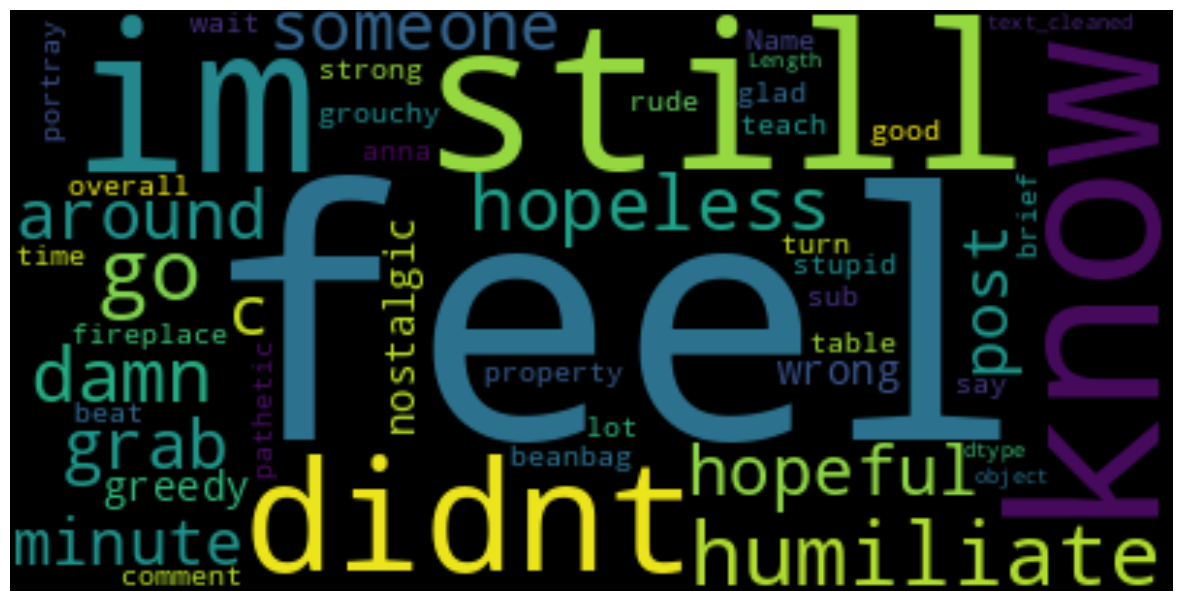

In [18]:
WordCloud = WordCloud(max_words=100,random_state=30,collocations=True).generate(str((train['text_cleaned'])))

plt.figure(figsize=(15, 8))
plt.imshow(WordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# 用Tensorflow标记化

In [19]:
num_words = 10000
# Out Of Vocabulary"的缩写，表示词汇表中不存在的单词，当遇到不在词汇表中的单词时，通常会将其视为 <OOV>，这个标记表示未知单词
# 使用 Keras 的 Tokenizer 对训练数据进行拟合（fit）的一个步骤。Tokenization 是将文本转换为数字序列的过程，其中每个单词被映射到一个唯一的整数索引
tokenizer = Tokenizer(num_words=num_words, oov_token='<OOV>')
tokenizer.fit_on_texts(train['text_cleaned'])

word_index = tokenizer.word_index

In [20]:
# 对训练数据集和验证数据集进行标记化
Tokenized_train = tokenizer.texts_to_sequences(train['text_cleaned'])
Tokenized_val = tokenizer.texts_to_sequences(validation['text_cleaned'])

In [21]:
print('非标记化版本: ', train['text_cleaned'][0])
print('标记化版本: ', tokenizer.texts_to_sequences([train['text_cleaned'][0]]))
print('--'*50)
print('非标记化版本: ', train['text_cleaned'][10])
print('标记化版本: ', tokenizer.texts_to_sequences([train['text_cleaned'][10]]))
print('--'*50)
print('非标记化版本: ', train['text'][100])
print('标记化版本: ', tokenizer.texts_to_sequences([train['text_cleaned'][100]]))

非标记化版本:  didnt feel humiliate
标记化版本:  [[56, 2, 559]]
----------------------------------------------------------------------------------------------------
非标记化版本:  feel like make suffer see mean something
标记化版本:  [[2, 3, 6, 393, 31, 102, 25]]
----------------------------------------------------------------------------------------------------
非标记化版本:  i wont let me child cry it out because i feel that loving her and lily when she was little was going to be opportunities that only lasted for those short few months
标记化版本:  [[356, 82, 289, 230, 2, 14, 3422, 13, 7, 2310, 87, 742, 263]]


# 填充

In [22]:
# 对文本数据进行填充（padding）的操作，这是为了确保所有的文本序列在输入模型之前具有相同的长度
# 在深度学习中，通常要求输入序列的长度相同，以便于批处理（batching）和并行计算。
# padding='pre' 表示在列前填充
maxlen = 40
Padded_train = pad_sequences(Tokenized_train, maxlen=maxlen, padding='pre')
Padded_val = pad_sequences(Tokenized_val, maxlen=maxlen, padding='pre')

print('未填充的版本: ', tokenizer.texts_to_sequences([train['text_cleaned'][0]]))
print('填充的版本: ', Padded_train[0])
print('--'*50)
print('未填充的版本: ', tokenizer.texts_to_sequences([train['text_cleaned'][10]]))
print('填充的版本: ', Padded_train[10])

未填充的版本:  [[56, 2, 559]]
填充的版本:  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  56   2 559]
----------------------------------------------------------------------------------------------------
未填充的版本:  [[2, 3, 6, 393, 31, 102, 25]]
填充的版本:  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   2   3   6
 393  31 102  25]


# 创建模型

In [23]:
# 创建 Sequential 模型，是 Keras 中最简单的一种模型类型，按顺序堆叠层
model = Sequential()

# 这是一个嵌入层（Embedding Layer）；它将整数编码的单词映射到具有固定大小的稠密向量（16维）中。num_words 是词汇表的大小，maxlen 是输入序列的长度
model.add(Embedding(num_words, 16, input_length=maxlen))
# 这是一个全局平均池化层，对输入的所有时间步骤计算平均值，将输入序列的长度降至1。这有助于减小序列长度，提取关键信息
model.add(GlobalAvgPool1D())

# 这是三个双向 LSTM 层，每个都带有一个激活函数为 'relu' 的激活函数。每个 LSTM 层的返回序列设置为 True，表示输出完整的序列而不仅仅是最后一个时间步的输出
# 在每个 LSTM 层之后，都添加了一个 Dropout 层，用于随机断开一定比例的神经元，以防止过拟合。
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True, activation='relu'))
model.add(Dropout(0.3))

tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, activation='relu', return_sequences=True))
model.add(Dropout(0.3))

tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, activation='relu'))
model.add(Dropout(0.3))

# 这是一个密集连接层（Dense Layer），具有6个输出单元，使用 softmax 激活函数。这是因为模型的任务是对6个类别进行分类
model.add(Dense(6, activation='softmax'))

# 这一行编译了模型，指定了损失函数为稀疏分类交叉熵（sparse categorical crossentropy），优化器为 'adam'，并使用准确度作为评估指标
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 显示每个层的参数数量和总参数数量等信息，助于了解模型的整体结构
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 16)            160000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 6)                 102       
                                                        

# 训练模型

In [24]:
# 对训练集和验证集中的标签（label）进行替换，将数字标签装换为文本标签
label_ = {"悲伤": 0, "高兴": 1, "喜爱": 2, "愤怒": 3, "恐惧": 4, "惊讶": 5}
train['label'] = train['label'].replace(label_)
validation['label'] = validation['label'].replace(label_)

train.head()

,text,label,length_of_text,text_tokenized,text_stop,text_lemmatized,text_cleaned
0,i didnt feel humiliated,0,4,"[i, didnt, feel, humiliated]","[didnt, feel, humiliated]","[didnt, feel, humiliate]",didnt feel humiliate
1,i can go from feeling so hopeless to so damned...,0,21,"[i, can, go, from, feeling, so, hopeless, to, ...","[go, feeling, hopeless, damned, hopeful, aroun...","[go, feel, hopeless, damn, hopeful, around, so...",go feel hopeless damn hopeful around someone c...
2,im grabbing a minute to post i feel greedy wrong,3,10,"[im, grabbing, a, minute, to, post, i, feel, g...","[im, grabbing, minute, post, feel, greedy, wrong]","[im, grab, minute, post, feel, greedy, wrong]",im grab minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,2,18,"[i, am, ever, feeling, nostalgic, about, the, ...","[ever, feeling, nostalgic, fireplace, know, st...","[ever, feel, nostalgic, fireplace, know, still...",ever feel nostalgic fireplace know still property
4,i am feeling grouchy,3,4,"[i, am, feeling, grouchy]","[feeling, grouchy]","[feel, grouchy]",feel grouchy


In [36]:
# 创建了一个 Early Stopping 回调函数。Early Stopping 是一种用于防止过拟合的技术，它在模型在验证集上的性能不再提高时停止训练，以避免过度拟合。具体参数说明：
# monitor='val_accuracy'：监视验证集上的准确度。
# mode='auto'：模式自动选择，如果 monitor 是准确度，那么 'auto' 会选择 'max' 模式。
# patience=5：如果在5个连续的训练周期中验证集上的准确度没有提高，就触发 Early Stopping。
# restore_best_weights=True：在停止训练后，回滚到在验证集上性能最好的那一轮的权重。
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='auto', patience=5, restore_best_weights=True)

# 模型的训练
# epochs=80 表示训练的最大轮数为80
# 模型使用 Padded_train 和 train['label'] 进行训练，使用验证集 (Padded_val, validation['label']) 进行验证
# 同时，通过 callbacks 参数传递 Early Stopping 回调函数，以便在训练期间启用 Early Stopping
# 训练的历史信息存储在 hist 变量中
epochs = 80
hist = model.fit(Padded_train,
         train['label'],
         epochs=epochs,
         validation_data=(Padded_val, validation['label']),
         callbacks=[early_stopping])

# 损失（Loss）：衡量模型在训练数据上的拟合程度。损失越低越好。
# 准确度（Accuracy）：模型在训练集或验证集上的分类准确度。它表示模型正确预测的样本比例。
# 训练过程中可能出现的一些观察：
  #随着训练的进行，训练集和验证集上的损失和准确度可能会有所改善。
  #"Early Stopping" 回调函数可能会在验证集上的准确度不再提高时停止训练，以防止过拟合。
  #可以根据验证集的性能调整模型架构、超参数等，以提高模型的泛化性能。
model.save("/content/model2", save_format="tf")


Epoch 1/80
500/500 [==============================] - 1s 3ms/step - loss: 0.3036 - accuracy: 0.9078 - val_loss: 0.3688 - val_accuracy: 0.8830
Epoch 2/80
500/500 [==============================] - 1s 2ms/step - loss: 0.2979 - accuracy: 0.9108 - val_loss: 0.3654 - val_accuracy: 0.8795
Epoch 3/80
500/500 [==============================] - 1s 2ms/step - loss: 0.2974 - accuracy: 0.9114 - val_loss: 0.3644 - val_accuracy: 0.8875
Epoch 4/80
500/500 [==============================] - 2s 3ms/step - loss: 0.2898 - accuracy: 0.9143 - val_loss: 0.3659 - val_accuracy: 0.8860
Epoch 5/80
500/500 [==============================] - 1s 3ms/step - loss: 0.2829 - accuracy: 0.9136 - val_loss: 0.3638 - val_accuracy: 0.8820
Epoch 6/80
500/500 [==============================] - 2s 3ms/step - loss: 0.2855 - accuracy: 0.9114 - val_loss: 0.3670 - val_accuracy: 0.8780
Epoch 7/80
500/500 [==============================] - 2s 4ms/step - loss: 0.2766 - accuracy: 0.9139 - val_loss: 0.3649 - val_accuracy: 0.8770
Epoch 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 训练和验证损失图

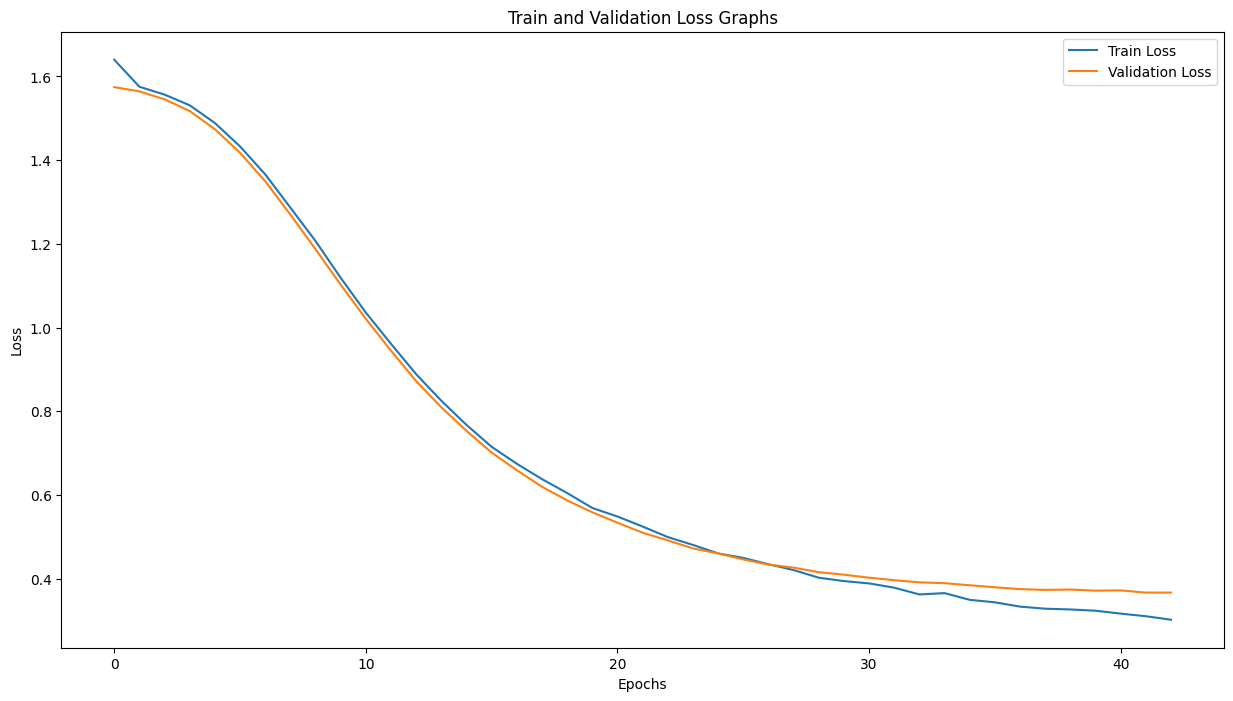

In [26]:
plt.figure(figsize=(15, 8))
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss Graphs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 准备测试数据集

In [27]:
test['text_tokenized'] = test['text'].apply(tokenization)
test['text_stop'] = test['text_tokenized'].apply(stopwords_remove)
test['text_lemmatized'] = test['text_stop'].apply(lemmatization)
test['text_cleaned'] = test['text_lemmatized'].str.join(' ')

Tokenized_test = tokenizer.texts_to_sequences(test['text_cleaned'])
Padded_test = pad_sequences(Tokenized_test, maxlen=maxlen, padding='pre')

test['label'] = test['label'].replace(label_)

test_evaluate = model.evaluate(Padded_test, test['label'])

63/63 [==============================] - 0s 1ms/step - loss: 0.3759 - accuracy: 0.8745


In [28]:
test.head()

,text,label,text_tokenized,text_stop,text_lemmatized,text_cleaned
0,im feeling rather rotten so im not very ambiti...,0,"[im, feeling, rather, rotten, so, im, not, ver...","[im, feeling, rather, rotten, im, ambitious, r...","[im, feel, rather, rotten, im, ambitious, right]",im feel rather rotten im ambitious right
1,im updating my blog because i feel shitty,0,"[im, updating, my, blog, because, i, feel, shi...","[im, updating, blog, feel, shitty]","[im, update, blog, feel, shitty]",im update blog feel shitty
2,i never make her separate from me because i do...,0,"[i, never, make, her, separate, from, me, beca...","[never, make, separate, ever, want, feel, like...","[never, make, separate, ever, want, feel, like...",never make separate ever want feel like ashamed
3,i left with my bouquet of red and yellow tulip...,1,"[i, left, with, my, bouquet, of, red, and, yel...","[left, bouquet, red, yellow, tulips, arm, feel...","[leave, bouquet, red, yellow, tulips, arm, fee...",leave bouquet red yellow tulips arm feel sligh...
4,i was feeling a little vain when i did this one,0,"[i, was, feeling, a, little, vain, when, i, di...","[feeling, little, vain, one]","[feel, little, vain, one]",feel little vain one


# 在测试数据集中进行预测

In [29]:
def make_predictions(text_input):
    text_input = str(text_input)
    text_input = tokenization(text_input)
    text_input = stopwords_remove(text_input)
    text_input = lemmatization(text_input)
    text_input = ' '.join(text_input)
    text_input = tokenizer.texts_to_sequences([text_input])
    text_input = pad_sequences(text_input, maxlen=maxlen, padding='pre')
    text_input = np.argmax(model.predict(text_input))

    if text_input == 0:
        print('预测情感: 悲伤')
    elif text_input == 1:
        print('预测情感: 高兴')
    elif text_input == 2:
        print('预测情感: 喜爱')
    elif text_input == 3:
        print('预测情感: 愤怒')
    elif text_input == 4:
        print('预测情感: 恐惧')
    else:
        print('预测情感: 惊讶')
    return text_input

label_ = {0: "悲伤", 1: "高兴", 2: "喜爱", 3: "愤怒", 4: "恐惧", 5: "惊讶"}
test['label'] = test['label'].replace(label_)

i = random.randint(0, len(test) - 1)

print('测试预测内容:', test['text'][i])
print(' ')
print('实际情感:', test['label'][i])
make_predictions(test['text'][i])
print('-'*50)
print('测试预测内容:', test['text'][i+1])
print(' ')
print('实际情感:', test['label'][i+1])
make_predictions(test['text'][i+1])

测试预测内容: i feel like uninstalling skype deactivateing all of my facebook amp hatena accounts since im becoming a hateful person amp i dont want to get any worse than i am right now
 
实际情感: 愤怒
1/1 [==============================] - 0s 69ms/step
预测情感: 愤怒
--------------------------------------------------
测试预测内容: i began to feel shaky and nauseous and yearned for my connection to cairns to make up for some of the deprivation
 
实际情感: 恐惧
1/1 [==============================] - 0s 22ms/step
预测情感: 恐惧


4

# 测试数据集的混淆矩阵

63/63 [==============================] - 0s 2ms/step


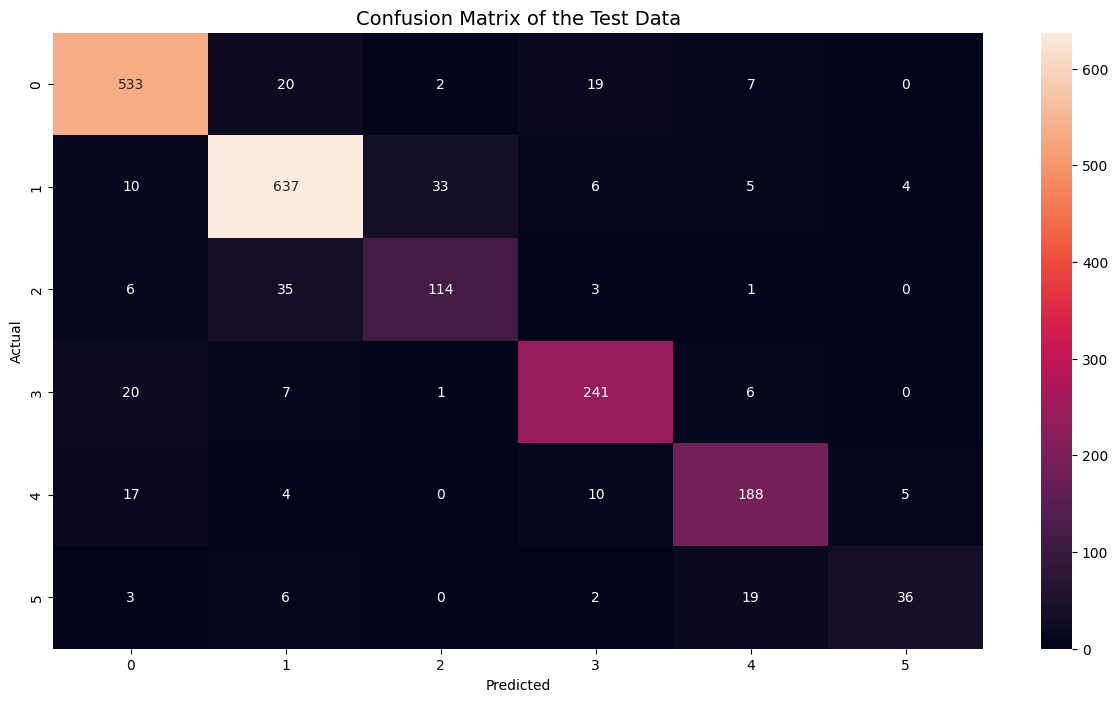

In [30]:
from sklearn.metrics import confusion_matrix
import numpy as np

label_ = {"悲伤": 0, "高兴": 1, "喜爱": 2, "愤怒": 3, "恐惧": 4, "惊讶": 5}
#label_ = {"Sadness": 0, "Joy": 1, "Love": 2, "Anger": 3, "Fear": 4, "Surprise": 5}
test['label'] = test['label'].replace(label_)

predictions = model.predict(Padded_test)
pred = np.argmax(predictions, axis=1)

# pred = model.predict_classes(Padded_test)
plt.figure(figsize=(15, 8))
conf_mat = confusion_matrix(test['label'].values, pred)
conf_mat = pd.DataFrame(conf_mat, columns=np.unique(test['label']), index=np.unique(pred))
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
sns.heatmap(conf_mat, annot=True, fmt='g')
plt.title('Confusion Matrix of the Test Data', fontsize=14)
plt.show()

# 预测

In [31]:
# 我喜欢人民大学
make_predictions("i love RUC!!!")

1/1 [==============================] - 0s 15ms/step
预测情感: 喜爱


2

In [32]:
# 胡鹤老师的线上课程马上结束了，我会非常想念它
make_predictions("Teacher Hu He's online course will be over soon, I will miss it very much")

1/1 [==============================] - 0s 15ms/step
预测情感: 悲伤


0

In [33]:
# 五月天乐队竟然会假唱，简直让人难以置信
make_predictions("It's hard to believe that Mayday can lip-sync")

1/1 [==============================] - 0s 15ms/step
预测情感: 悲伤


0